# 🧱 Tiny CNN 训练 Notebook

面向 TinyML SoC 的玻璃破碎 baseline：Notebook 仅负责 orchestrator，具体逻辑封装在 `src/` helper 中。

## ✅ 执行步骤
1. Inspect：加载 balanced index，确认分布。
2. K-Fold：针对全部 fold 运行训练，保存各折 checkpoint。
3. Analyze：可视化各折指标，挑选最佳 fold。
4. Drill-down：查看最佳 fold 的训练曲线、混淆矩阵。
5. Export：保存最佳权重 & 历史，并导出 ONNX 供后续 INT8 流水线使用。

In [1]:
# Cell: Environment & Imports
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from src.config import SEED
from src.datasets import load_index_df, build_dataloaders
from src.models import TinyGlassNet, count_parameters
from src.training import run_kfold_training
from src.metrics import confusion_matrix, plot_confusion_matrix
from src.export import export_to_onnx

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
sns.set_theme(style="whitegrid")


## ⚙️ 配置与超参
集中管理数据路径、折划分、训练/导出参数以及更精细的超参（class weight、grad clip）。

In [2]:
# Cell: Experiment Configuration
INDEX_CANDIDATES = [
    Path('cache/mel64/mel64_multi/index_balanced.csv'),
    Path('cache/mel64/mel64_multi/index_balanced.parquet'),
    Path('cache/index_balanced.parquet'),
    Path('cache/index_balanced.csv'),
]
INDEX_PATH = next((p for p in INDEX_CANDIDATES if p.exists()), INDEX_CANDIDATES[-1])

K_FOLD_LIST = (1, 2, 3, 4, 5)
BEST_METRIC = 'f1'  # 可切换为 'recall' 等

BATCH_SIZE = 64
NUM_WORKERS = 0
EPOCHS = 60
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
EARLY_STOPPING = 8
LR_PATIENCE = 4
LR_FACTOR = 0.5
CLASS_WEIGHTS = (1.0, 1.3)  # background, glass
GRAD_CLIP_NORM = 1.0
SMOKE_TEST = False
SMOKE_LIMIT = 128 if SMOKE_TEST else None
COLLATE_MAX_FRAMES = None

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_DIR = Path('cache/experiments')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
KFOLD_DIR = OUTPUT_DIR / 'kfold'
ONNX_PATH = OUTPUT_DIR / 'tinyglassnet_best.onnx'


## 🛠️ Helper Builders
定义模型、损失、优化器、调度器构造方法，以及 DataLoader 的公共配置。

In [3]:
# Cell: Builder Functions
loader_kwargs = dict(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    smoke_limit=SMOKE_LIMIT,
    collate_max_frames=COLLATE_MAX_FRAMES,
)

def build_model():
    return TinyGlassNet()

class_weights_tensor = torch.tensor(CLASS_WEIGHTS, dtype=torch.float32)

def build_criterion():
    return nn.BCEWithLogitsLoss()
    
def build_optimizer(params):
    return torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


def build_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=LR_FACTOR)

print(f"Model params: {count_parameters(build_model()):,}")


Model params: 23,314


## 📁 加载索引并检查分布

In [4]:
# Cell: Load Balanced Index
index_df = load_index_df(INDEX_PATH)
print(f'Loaded index: {INDEX_PATH} | samples={len(index_df)}')
# Ensure path column exists (compat with older indices)
if 'path' not in index_df.columns:
    alt_cols = [c for c in ['filepath','mel_path'] if c in index_df.columns]
    if alt_cols:
        index_df['path'] = index_df[alt_cols[0]]
        print(f"path missing; using {alt_cols[0]} instead")
    else:
        raise KeyError("Index is missing 'path' column; regenerate cache/index_balanced.csv from prepare_new.ipynb")
display(index_df.head())
display(index_df['label'].value_counts().rename('count'))
display(index_df.groupby(['label', 'fold_id']).size().unstack(fill_value=0))


Loaded index: cache/mel64/mel64_multi/index_balanced.csv | samples=2000


,path,labels,label_ids,label,fold_id,source_filename,clip_id,window_id,pipeline_name,augment_desc,source_type
0,/workspace/cache/mel64/mel64_multi/glass/fold1...,['glass'],[0],glass,1,1-20133-A-39.wav,1-20133-A-39,w00,base,base,glass_base
1,/workspace/cache/mel64/mel64_multi/glass/fold1...,['glass'],[0],glass,1,1-20133-A-39.wav,1-20133-A-39,w00,shift_gain,shift_gain(time_shift+gain),glass_aug
2,/workspace/cache/mel64/mel64_multi/glass/fold1...,['glass'],[0],glass,1,1-20133-A-39.wav,1-20133-A-39,w00,shift_gain,shift_gain(time_shift+gain),glass_aug
3,/workspace/cache/mel64/mel64_multi/glass/fold1...,['glass'],[0],glass,1,1-20133-A-39.wav,1-20133-A-39,w00,stretch_reverb,stretch_reverb(time_stretch+reverb),glass_aug
4,/workspace/cache/mel64/mel64_multi/glass/fold1...,['glass'],[0],glass,1,1-20133-A-39.wav,1-20133-A-39,w00,shift_mix,shift_mix(time_shift+mix),glass_aug


label
background    800
gunshot       632
glass         568
Name: count, dtype: int64

fold_id,1,2,3,4,5
label,,,,,
background,139,176,165,197,123
glass,96,88,96,208,80
gunshot,112,176,152,88,104


## 🔁 运行 K-fold 训练

In [5]:
# Cell: Run K-fold Training
kfold_records = run_kfold_training(
    k=len(K_FOLD_LIST),
    fold_ids=K_FOLD_LIST,
    index_df=index_df,
    build_loaders_fn=build_dataloaders,
    model_builder=build_model,
    criterion_builder=build_criterion,
    optimizer_builder=build_optimizer,
    scheduler_builder=build_scheduler,
    device=DEVICE,
    output_dir=KFOLD_DIR,
    epochs=EPOCHS,
    early_stopping=EARLY_STOPPING,
    grad_clip_norm=GRAD_CLIP_NORM,
    **loader_kwargs,
)
if not kfold_records:
    raise RuntimeError("K-fold training produced no records.")

kfold_df = pd.DataFrame([
    {
        "fold": rec["fold"],
        **rec["metrics"],
        "checkpoint_path": rec["checkpoint_path"],
    }
    for rec in kfold_records
])
display(kfold_df)
display(kfold_df.describe())


=== Fold 1: train=(2, 3, 4, 5) val=(1,) ===
[Epoch 01] train_loss=0.6543 val_loss=0.6365 val_acc=0.401 val_f1=0.000
[Epoch 02] train_loss=0.5961 val_loss=0.5764 val_acc=0.401 val_f1=0.000
[Epoch 03] train_loss=0.5732 val_loss=0.5591 val_acc=0.438 val_f1=0.106
[Epoch 04] train_loss=0.5487 val_loss=0.5459 val_acc=0.467 val_f1=0.173
[Epoch 05] train_loss=0.5310 val_loss=0.5325 val_acc=0.496 val_f1=0.302
[Epoch 06] train_loss=0.5174 val_loss=0.5319 val_acc=0.461 val_f1=0.186
[Epoch 07] train_loss=0.5010 val_loss=0.5167 val_acc=0.504 val_f1=0.330
[Epoch 08] train_loss=0.4828 val_loss=0.4982 val_acc=0.490 val_f1=0.273
[Epoch 09] train_loss=0.4724 val_loss=0.4921 val_acc=0.550 val_f1=0.350
[Epoch 10] train_loss=0.4541 val_loss=0.4691 val_acc=0.550 val_f1=0.404
[Epoch 11] train_loss=0.4464 val_loss=0.4686 val_acc=0.625 val_f1=0.572
[Epoch 12] train_loss=0.4349 val_loss=0.4463 val_acc=0.657 val_f1=0.627
[Epoch 13] train_loss=0.4204 val_loss=0.4306 val_acc=0.677 val_f1=0.628
[Epoch 14] train_los

,fold,loss,accuracy,precision,recall,f1,checkpoint_path
0,1,0.284365,0.769452,0.890783,0.684524,0.774048,cache/experiments/kfold/tinyglassnet_fold1.pt
1,2,0.336173,0.745455,0.762778,0.718750,0.738592,cache/experiments/kfold/tinyglassnet_fold2.pt
2,3,0.230070,0.828087,0.866511,0.820998,0.841478,cache/experiments/kfold/tinyglassnet_fold3.pt
3,4,0.302440,0.791075,0.895996,0.703890,0.788359,cache/experiments/kfold/tinyglassnet_fold4.pt
4,5,0.215962,0.811075,0.896970,0.758173,0.821635,cache/experiments/kfold/tinyglassnet_fold5.pt


,fold,loss,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.000000,0.273802,0.789029,0.862607,0.737267,0.792822
std,1.581139,0.050199,0.032779,0.057163,0.054052,0.040345
min,1.000000,0.215962,0.745455,0.762778,0.684524,0.738592
25%,2.000000,0.230070,0.769452,0.866511,0.703890,0.774048
50%,3.000000,0.284365,0.791075,0.890783,0.718750,0.788359
75%,4.000000,0.302440,0.811075,0.895996,0.758173,0.821635
max,5.000000,0.336173,0.828087,0.896970,0.820998,0.841478


## 📊 K-fold 指标可视化

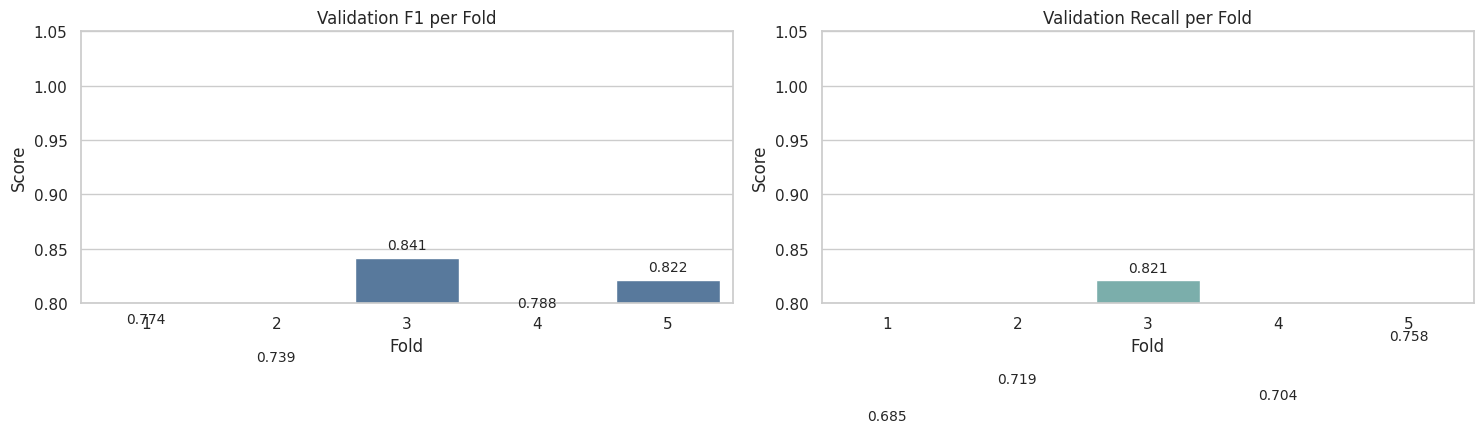

In [6]:
# Cell: Visualize Fold Metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_plot = kfold_df.dropna(subset=["f1", "recall"])  # 只保留有效折

palette = ["#4C78A8"] * len(kfold_df)
sns.barplot(data=kfold_df, x="fold", y="f1", ax=axes[0], color="#4C78A8")
for bar, value in zip(axes[0].patches, kfold_df["f1" ]):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{value:.3f}", ha="center", va="bottom", fontsize=10)
sns.barplot(data=kfold_df, x="fold", y="recall", ax=axes[1], color="#72B7B2")
for bar, value in zip(axes[1].patches, kfold_df["recall" ]):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{value:.3f}", ha="center", va="bottom", fontsize=10)
axes[0].set_title("Validation F1 per Fold")
axes[1].set_title("Validation Recall per Fold")
for ax in axes:
    ax.set_ylim(0.8, 1.05)
    ax.set_xlabel("Fold")
    ax.set_ylabel("Score")

plt.tight_layout()


## 🎯 选择最佳 Fold

In [7]:
# Cell: Select Best Fold
metric_key = BEST_METRIC
best_record = max(kfold_records, key=lambda rec: rec["metrics"].get(metric_key, float("-inf")))
best_fold = best_record["fold"]
best_metrics = best_record["metrics"]
print(f"Best fold: {best_fold} based on metric '{metric_key}' -> {best_metrics}")

best_history_df = pd.DataFrame(best_record["history"])


Best fold: 3 based on metric 'f1' -> {'loss': 0.23006979399529842, 'accuracy': 0.8280871510505676, 'precision': 0.8665106296539307, 'recall': 0.8209978342056274, 'f1': 0.841478168964386}


## 📈 最佳 Fold 训练曲线

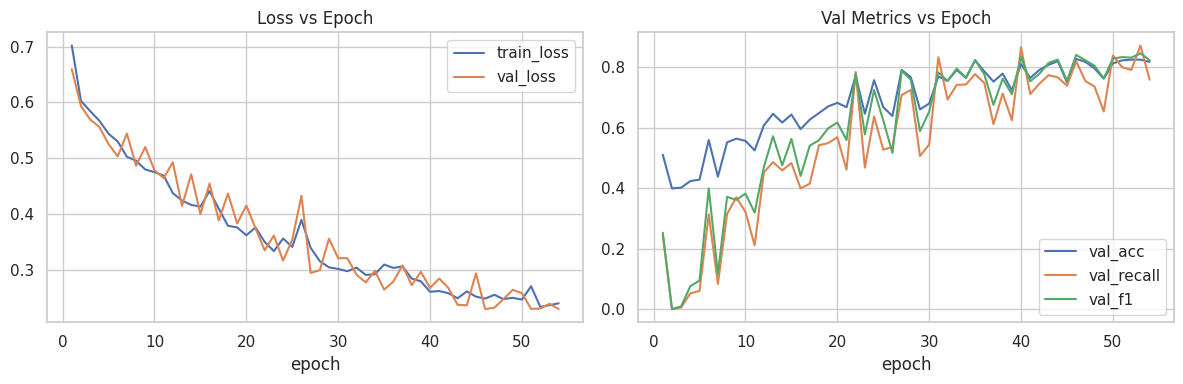

In [8]:
# Cell: Plot Training Curves
if best_history_df.empty:
    print("No history captured for best fold.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    best_history_df.plot(x="epoch", y=["train_loss", "val_loss"], ax=axes[0])
    axes[0].set_title("Loss vs Epoch")
    best_history_df.plot(x="epoch", y=["val_acc", "val_recall", "val_f1"], ax=axes[1])
    axes[1].set_title("Val Metrics vs Epoch")
    plt.tight_layout()


## 🔍 混淆矩阵 (最佳 Fold)

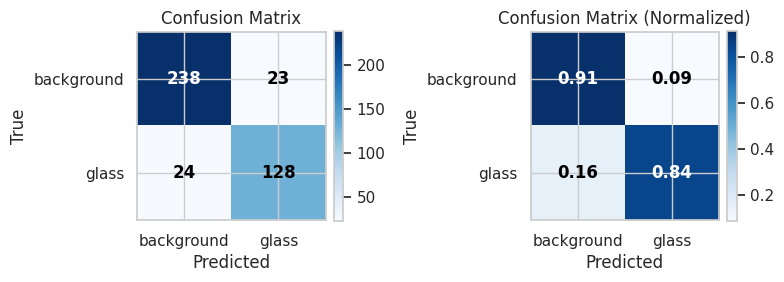

In [9]:
# Cell: Confusion Matrix
best_state = best_record["best_state"]
best_preds = best_state.get("predictions")
best_targets = best_state.get("targets")
if best_preds is None or best_targets is None:
    print("Predictions not cached; cannot plot confusion matrix.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    cm_raw = confusion_matrix(best_preds, best_targets, num_classes=2, normalize=False)
    cm_norm = confusion_matrix(best_preds, best_targets, num_classes=2, normalize=True)
    plot_confusion_matrix(cm_raw, class_names=['background', 'glass'], normalize=False, ax=axes[0])
    plot_confusion_matrix(cm_norm, class_names=['background', 'glass'], normalize=True, ax=axes[1])
    plt.tight_layout()


## 💾 保存最佳 Fold 产物

In [10]:
# Cell: Persist Best Fold Checkpoint & History
best_ckpt_src = best_record.get('checkpoint_path')
if best_ckpt_src is None:
    raise RuntimeError('Best fold checkpoint path missing; ensure output_dir is set in run_kfold_training().')
best_ckpt_src = Path(best_ckpt_src)
best_ckpt_dst = OUTPUT_DIR / 'tinyglassnet_best.pt'
shutil.copy(best_ckpt_src, best_ckpt_dst)
print(f'Checkpoint copied to {best_ckpt_dst}')

history_path = OUTPUT_DIR / 'tinyglassnet_best_history.csv'
best_history_df.to_csv(history_path, index=False)
print(f'History saved to {history_path}')


Checkpoint copied to cache/experiments/tinyglassnet_best.pt
History saved to cache/experiments/tinyglassnet_best_history.csv


## 📦 导出 ONNX (最佳 Fold)

In [11]:
# Cell: Export ONNX
best_model = build_model().to(DEVICE)
best_model.load_state_dict(best_state["model"])
best_model.eval()
example_mel = np.load(index_df.iloc[0]["path"])
example_input = torch.from_numpy(example_mel).unsqueeze(0).unsqueeze(0).float()
onnx_path = export_to_onnx(best_model.to("cpu"), example_input, ONNX_PATH)
print(f"Exported ONNX to {onnx_path}")
best_model.to(DEVICE)


Exported ONNX to cache/experiments/tinyglassnet_best.onnx


TinyGlassNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)